# Applied Data Science Capstone
This notebook is for the IBM data science Capstone project.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import requests
import numpy as np
# import k-means from clustering stage
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
import json

import folium # map rendering library #!pip install folium
%matplotlib inline

# Data preprocessing

In [2]:
# Data in toronto
source = requests.get\
    (\
    'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=862527922'\
    ).text
# Extracted Data from Wiki
postal_code=BeautifulSoup(source,'lxml')
df=pd.read_html(str(postal_code.table))[0][1:]
df.columns=['Postal Code', 'Borough','Neighborhood']

# Only process the cells that have an assigned borough.
idx=df[df['Borough']=="Not assigned"].index
df.drop(idx, axis=0, inplace=True)

# More than one neighborhood can exist in one postal code area - Combine into one column
tor=df.groupby(['Postal Code', 'Borough'], sort = False).agg( ', '.join).reset_index()

# Importing lat/lon 
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')

# Merge two datasets
df_toronto = pd.merge(tor, lat_lon, on = 'Postal Code')
df_toronto=df_toronto.drop(['Postal Code'],axis=1)

df_toronto['City'] = 'Toronto';
# Quickly examine df
df_toronto.head(2)

,Borough,Neighborhood,Latitude,Longitude,City
0,North York,Parkwoods,43.753259,-79.329656,Toronto
1,North York,Victoria Village,43.725882,-79.315572,Toronto


In [3]:
# Data in New York
with open('/Users/xiaoxiny/Downloads/newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
ny_neighborhoods = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_newyork = pd.DataFrame(columns=column_names)

# loop through the data and fill the dataframe
for data in ny_neighborhoods:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_newyork = df_newyork.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

df_newyork['City'] = 'New York';
# Quickly examine df
df_newyork.head(2)

,Borough,Neighborhood,Latitude,Longitude,City
0,Bronx,Wakefield,40.894705,-73.847201,New York
1,Bronx,Co-op City,40.874294,-73.829939,New York


In [4]:
CLIENT_ID = '3AFF1D4QUNI0DKVAF5I3PUC3AZ23FS1S43DZLZCTGWLEXZLE' # your Foursquare ID
CLIENT_SECRET = '2UQP50K3FFRL04EOCLL2HJG33GLM25DOOP0U24PO1BH00ITD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# Function #1: to get nearbyy venues 
# Function #2: group venues and get frequency
# Function #3: top venues in region
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, lat, lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def groupVenues(df_city): 
    # one hot encoding
    city_onehot = pd.get_dummies(df_city[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    city_onehot['Neighborhood'] = df_city['Neighborhood'] 

    # move neighborhood column to the first column
    fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
    city_onehot = city_onehot[fixed_columns]

    city_grouped = city_onehot.groupby('Neighborhood').mean().reset_index()
    return city_grouped

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [5]:
# Pipeline the four functions above
def return_full_grouped_sorted_df(df_input):
    df_cityVenues = getNearbyVenues(names=df_input['Neighborhood'],
                                       latitudes=df_newyork['Latitude'],
                                       longitudes=df_newyork['Longitude']
                                      )
    df_groupVenues= groupVenues(df_cityVenues)

    num_top_venues = 10
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    df_VenuesSorted = pd.DataFrame(columns=columns)
    df_VenuesSorted['Neighborhood'] = df_groupVenues['Neighborhood']

    for ind in np.arange(df_groupVenues.shape[0]):
        df_VenuesSorted.iloc[ind, 1:] = return_most_common_venues(df_groupVenues.iloc[ind, :], num_top_venues)

    return df_cityVenues,df_groupVenues,df_VenuesSorted

In [6]:
tor_cityVenues,tor_groupVenues,tor_VenuesSorted = return_full_grouped_sorted_df(df_toronto)
nyc_cityVenues,nyc_groupVenues,nyc_VenuesSorted = return_full_grouped_sorted_df(df_newyork)

In [7]:
tor_cityVenues= pd.read_csv('tor_cityVenues.csv')
tor_groupVenues= pd.read_csv('tor_groupVenues.csv')
tor_VenuesSorted= pd.read_csv('tor_VenuesSorted.csv')
nyc_cityVenues= pd.read_csv('nyc_cityVenues.csv')
nyc_groupVenues= pd.read_csv('nyc_groupVenues.csv')
nyc_VenuesSorted= pd.read_csv('nyc_VenuesSorted.csv')

In [8]:
# Initial data disovery - What are the most popular venues in NYC & Toronto
nyc_top_vc = nyc_cityVenues['Venue Category'].value_counts(normalize=True).\
                rename_axis('Venue Category').reset_index(name='Frequency')
nyc_top_vc['Frequency %'] = nyc_top_vc['Frequency']*100;nyc_top_vc['City'] = 'New York';

tor_top_vc = tor_cityVenues['Venue Category'].value_counts(normalize=True).\
                rename_axis('Venue Category').reset_index(name='Frequency')
tor_top_vc['Frequency %'] = tor_top_vc['Frequency']*100;tor_top_vc['City'] = 'Toronto'

#Select the top 20 venues in NYC & Tor
num_of_interest=20
top_vc = nyc_top_vc.head(num_of_interest).append(tor_top_vc.head(num_of_interest))

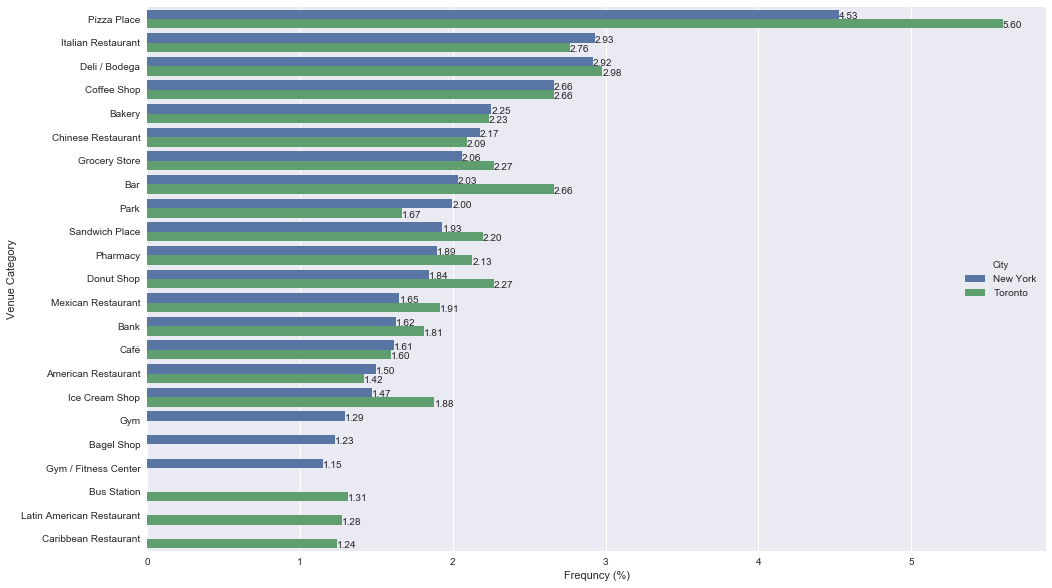

In [9]:
ax=plt.figure(figsize=(10*1.61,10))
ax = sns.barplot(x="Frequency %", y="Venue Category", hue="City", data=top_vc)
ax.set_xlabel('Frequncy (%)')

for p in ax.patches:
        percentage = '{:.2f}'.format(p.get_width())
        x = p.get_x() + p.get_width()+1.2*1e-4
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y))

## k-means

In [16]:
#prepare data
nyc_tor = nyc_groupVenues.append(tor_groupVenues)
nyc_tor_grouped_clustering = nyc_tor.drop('Neighborhood', 1).drop('Unnamed: 0', 1).dropna(axis='columns')

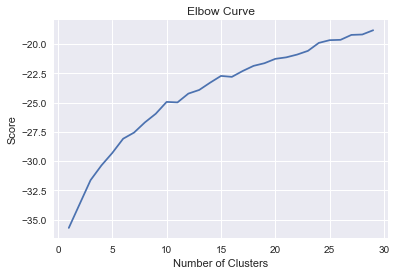

In [38]:
num_clusters = range(1, 30)

kmeans = [KMeans(n_clusters=i) for i in num_clusters]
score = [kmeans[i].fit(nyc_tor_grouped_clustering).score(nyc_tor_grouped_clustering) for i in range(len(kmeans))]

plt.plot(num_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')

plt.show()

In [39]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 3, 0, 1, 3, 1, 1, 1, 3], dtype=int32)

In [40]:
# add clustering labels
nyc_tor_VenuesSorted = nyc_VenuesSorted.append(tor_VenuesSorted)
nyc_tor_VenuesSorted.insert(0, 'Cluster Labels', kmeans.labels_)

data_merged = df_newyork.append(df_toronto)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
data_merged = data_merged.join(nyc_tor_VenuesSorted.set_index('Neighborhood'), on='Neighborhood').drop('Unnamed: 0', 1)\
             .dropna()

data_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,New York,3.0,Pharmacy,Gas Station,Sandwich Place,Caribbean Restaurant,Ice Cream Shop,Dessert Shop,Donut Shop,Laundromat,Entertainment Service,Ethiopian Restaurant
1,Bronx,Co-op City,40.874294,-73.829939,New York,3.0,Baseball Field,Bus Station,Pizza Place,Discount Store,Grocery Store,Mattress Store,Bagel Shop,Pharmacy,Park,Chinese Restaurant
2,Bronx,Eastchester,40.887556,-73.827806,New York,3.0,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Pizza Place,Chinese Restaurant,Seafood Restaurant,Fast Food Restaurant,Donut Shop,Platform
3,Bronx,Fieldston,40.895437,-73.905643,New York,3.0,River,Bus Station,Plaza,Yemeni Restaurant,Fast Food Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit
4,Bronx,Riverdale,40.890834,-73.912585,New York,3.0,Park,Food Truck,Bus Station,Gym,Home Service,Baseball Field,Plaza,Playground,Bank,Financial or Legal Service


In [41]:
# create map for NY
from geopy.geocoders import Nominatim
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data_merged['Latitude'], data_merged['Longitude'], data_merged['Neighborhood'], data_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[np.int(cluster-1)],
        fill=True,
        fill_color=rainbow[np.int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [42]:
# create map for NY
from geopy.geocoders import Nominatim
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data_merged['Latitude'], data_merged['Longitude'], data_merged['Neighborhood'], data_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[np.int(cluster-1)],
        fill=True,
        fill_color=rainbow[np.int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


# Cluster Analysis

In [43]:
for cluster_labels in range (kclusters):
    print("Cluster", cluster_labels, "has:",
        data_merged.loc[data_merged['Cluster Labels'] == cluster_labels, \
                        data_merged.columns[[1] + list(range(4, data_merged.shape[1]))]].shape[0], "out of", data_merged.shape[0])

Cluster 0 has: 15 out of 409
Cluster 1 has: 225 out of 409
Cluster 2 has: 10 out of 409
Cluster 3 has: 157 out of 409
Cluster 4 has: 2 out of 409


## Cluster 1

In [44]:
data_merged.loc[data_merged['Cluster Labels'] == 0, data_merged.columns[[1] + list(range(4, data_merged.shape[1]))]]

,Neighborhood,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
172,Breezy Point,New York,0.0,Supermarket,Monument / Landmark,Trail,Beach,Bus Stop,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory
179,Neponsit,New York,0.0,Beach,Yemeni Restaurant,Field,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm
193,Brookville,New York,0.0,Deli / Bodega,Home Service,Yemeni Restaurant,Fast Food Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory
198,New Brighton,New York,0.0,Bus Stop,Deli / Bodega,Park,Home Service,Playground,Daycare,Construction & Landscaping,Bowling Alley,Discount Store,Farm
202,Grymes Hill,New York,0.0,Bus Stop,Dog Run,Yemeni Restaurant,Field,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant
204,South Beach,New York,0.0,Beach,Pier,Deli / Bodega,Bus Stop,Athletics & Sports,Yemeni Restaurant,Fast Food Restaurant,Event Service,Event Space,Exhibit
206,Mariner's Harbor,New York,0.0,Italian Restaurant,Deli / Bodega,Bus Stop,Filipino Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant
224,Park Hill,New York,0.0,Bus Stop,Athletics & Sports,Hotel,Gym / Fitness Center,Coffee Shop,Fast Food Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
227,Arlington,New York,0.0,Bus Stop,Intersection,Grocery Store,American Restaurant,Deli / Bodega,Coffee Shop,Yemeni Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Event Service
232,Midland Beach,New York,0.0,Beach,Chinese Restaurant,Restaurant,Bus Stop,Sporting Goods Shop,Bookstore,Dessert Shop,Pet Store,Deli / Bodega,Basketball Court


## Cluster 2

In [45]:
data_merged.loc[data_merged['Cluster Labels'] == 1, data_merged.columns[[1] + list(range(4, data_merged.shape[1]))]]

,Neighborhood,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Woodlawn,New York,1.0,Deli / Bodega,Pizza Place,Pub,Playground,Bar,Rental Car Location,Train Station,Donut Shop,Pharmacy,Park
9,Williamsbridge,New York,1.0,Nightclub,Dance Studio,Caribbean Restaurant,Soup Place,Spa,Bar,Convenience Store,Farm,Ethiopian Restaurant,Food Court
12,City Island,New York,1.0,Harbor / Marina,Thrift / Vintage Store,Boat or Ferry,Seafood Restaurant,Park,Deli / Bodega,Bank,Liquor Store,Bar,Music Venue
22,Port Morris,New York,1.0,Furniture / Home Store,Brewery,Distillery,Baseball Field,Metro Station,Paper / Office Supplies Store,Peruvian Restaurant,Spanish Restaurant,Donut Shop,Latin American Restaurant
24,Hunts Point,New York,1.0,Food,Restaurant,Shipping Store,Bank,Grocery Store,Gourmet Shop,BBQ Joint,Pizza Place,Farmers Market,Spanish Restaurant
28,Throgs Neck,New York,1.0,Chinese Restaurant,Deli / Bodega,Asian Restaurant,Coffee Shop,Sports Bar,American Restaurant,Pizza Place,Juice Bar,Bar,Italian Restaurant
32,Van Nest,New York,1.0,Deli / Bodega,Pizza Place,Yemeni Restaurant,Hookah Bar,Playground,Coffee Shop,Donut Shop,Caribbean Restaurant,Bus Station,Middle Eastern Restaurant
33,Morris Park,New York,1.0,Pizza Place,Burger Joint,Deli / Bodega,Bakery,Italian Restaurant,Supermarket,Bank,Pharmacy,Coffee Shop,Sandwich Place
34,Belmont,New York,1.0,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Liquor Store,Food & Drink Shop,Fast Food Restaurant,Tattoo Parlor,Coffee Shop
39,Edgewater Park,New York,1.0,Italian Restaurant,Deli / Bodega,Pizza Place,Japanese Restaurant,Asian Restaurant,Sports Bar,Spa,Park,Liquor Store,Coffee Shop


## Cluster 3

In [46]:
data_merged.loc[data_merged['Cluster Labels'] == 2, data_merged.columns[[1] + list(range(4, data_merged.shape[1]))]]

,Neighborhood,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Clason Point,New York,2.0,Park,Recording Studio,Home Service,Grocery Store,Boat or Ferry,Pool,Bus Stop,South American Restaurant,Ethiopian Restaurant,Event Service
35,Spuyten Duyvil,New York,2.0,Park,Bank,Intersection,Pharmacy,Thai Restaurant,Tennis Stadium,Tennis Court,Falafel Restaurant,Entertainment Service,Ethiopian Restaurant
148,South Ozone Park,New York,2.0,Park,Deli / Bodega,Fast Food Restaurant,Bar,Sandwich Place,Hotel,Donut Shop,Home Service,Farm,Event Space
188,Laurelton,New York,2.0,Caribbean Restaurant,Train Station,Park,Yemeni Restaurant,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit
192,Somerville,New York,2.0,Park,Yemeni Restaurant,Fast Food Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant
203,Todt Hill,New York,2.0,Park,Yemeni Restaurant,Fast Food Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant
256,Randall Manor,New York,2.0,Park,Bus Stop,Pizza Place,Yemeni Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory
303,Bayswater,New York,2.0,Park,Playground,Yemeni Restaurant,Farmers Market,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory
27,Hillcrest Village,Toronto,2.0,Park,Boat or Ferry,Grocery Store,South American Restaurant,Bus Stop,Home Service,Recording Studio,Pool,Fish & Chips Shop,Filipino Restaurant
35,East Toronto,Toronto,2.0,Park,Intersection,Pharmacy,Tennis Court,Tennis Stadium,Thai Restaurant,Bank,Discount Store,Distillery,Food


## Cluster 4

In [47]:
data_merged.loc[data_merged['Cluster Labels'] == 3, data_merged.columns[[1] + list(range(4, data_merged.shape[1]))]]

,Neighborhood,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,New York,3.0,Pharmacy,Gas Station,Sandwich Place,Caribbean Restaurant,Ice Cream Shop,Dessert Shop,Donut Shop,Laundromat,Entertainment Service,Ethiopian Restaurant
1,Co-op City,New York,3.0,Baseball Field,Bus Station,Pizza Place,Discount Store,Grocery Store,Mattress Store,Bagel Shop,Pharmacy,Park,Chinese Restaurant
2,Eastchester,New York,3.0,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Pizza Place,Chinese Restaurant,Seafood Restaurant,Fast Food Restaurant,Donut Shop,Platform
3,Fieldston,New York,3.0,River,Bus Station,Plaza,Yemeni Restaurant,Fast Food Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit
4,Riverdale,New York,3.0,Park,Food Truck,Bus Station,Gym,Home Service,Baseball Field,Plaza,Playground,Bank,Financial or Legal Service
5,Kingsbridge,New York,3.0,Pizza Place,Supermarket,Sandwich Place,Mexican Restaurant,Bakery,Spanish Restaurant,Latin American Restaurant,Donut Shop,Bar,Fried Chicken Joint
6,Marble Hill,New York,3.0,Sandwich Place,Gym,Coffee Shop,Yoga Studio,Kids Store,Steakhouse,Supplement Shop,Miscellaneous Shop,Tennis Stadium,Bank
8,Norwood,New York,3.0,Pizza Place,Bank,Chinese Restaurant,Park,Pharmacy,Supermarket,Fast Food Restaurant,Sandwich Place,Deli / Bodega,Mexican Restaurant
10,Baychester,New York,3.0,Donut Shop,Gym / Fitness Center,Discount Store,Sandwich Place,Laundromat,Men's Store,Fast Food Restaurant,Pizza Place,Bank,Playground
11,Pelham Parkway,New York,3.0,Italian Restaurant,Bus Station,Pizza Place,Food,Café,Performing Arts Venue,Chinese Restaurant,Gift Shop,Bank,Smoke Shop


# Cluster 5

In [48]:
data_merged.loc[data_merged['Cluster Labels'] == 4, data_merged.columns[[1] + list(range(4, data_merged.shape[1]))]]

,Neighborhood,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
76,Mill Island,New York,4.0,Pool,Field,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm
76,Canada Post Gateway Processing Centre,Toronto,4.0,Pool,Yemeni Restaurant,Field,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
